In [1]:
# install transformer
!pip install transformers

In [2]:
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=fd5e465798755039147d4b2b9c1b1ce47ee51731735e346eaf8e859f9ae3abe6
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji


In [3]:
import re
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Train data
train_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_train.csv")
train_df.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [6]:
# Validate data
validate_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_valid.csv")
validate_df.head(5)

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


In [7]:
# Clean text column
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove special characters
    # text = re.sub(r"[^\w\s]", "", text)
    # Lowercasing
    text = text.lower()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
validate_df['clean_text'] = validate_df['text'].apply(clean_text)

In [8]:
train_df.head(5)

,text,label,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut


In [9]:
validate_df.head(5)

,text,label,clean_text
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp..."
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_dist_chart(df, run_mode):
    # Explore the distribution of classes
    # For train set
    train_class_distribution = Counter(df['label'])
    print("Class Distribution of train dataset:", train_class_distribution)

    # Convert the Counter object to a DataFrame for easier plotting
    class_dist_df = pd.DataFrame.from_dict(train_class_distribution, orient='index').reset_index()
    class_dist_df.columns = ['Class', 'Count']

    # Defining the plot size
    plt.figure(figsize=(5, 5))

    # Defining the values for x-axis, y-axis and creating the barplot
    plots = sns.barplot(x='Class', y='Count', data=class_dist_df)

    # Iterating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                      size=12, xytext=(0, 5),
                      textcoords='offset points')

    # Setting the title for the graph
    plt.title("{} data class-wise data count".format(run_mode))

    # Finally showing the plot
    plt.show()


Class Distribution of train dataset: Counter({2: 6178, 1: 1923, 0: 1442})


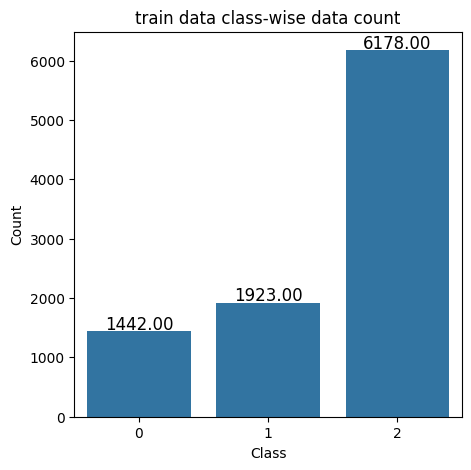

Class Distribution of train dataset: Counter({2: 1566, 1: 475, 0: 347})


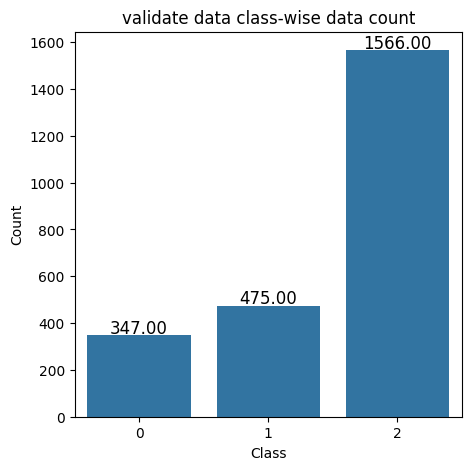

In [11]:
# Clean text column
counter=0
for df in [train_df, validate_df]:
    if counter == 0:
        run_mode="train"
    else:
        run_mode="validate"
    plot_class_dist_chart(df, run_mode)
    counter+=1

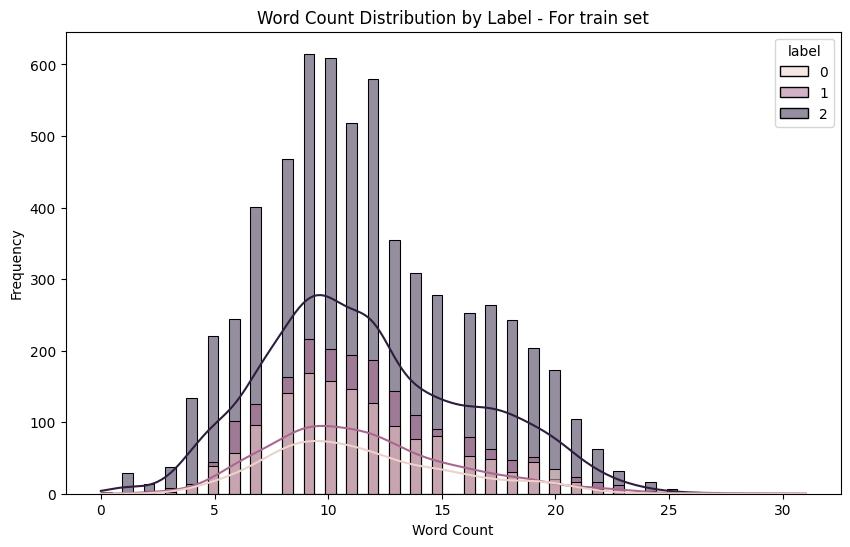

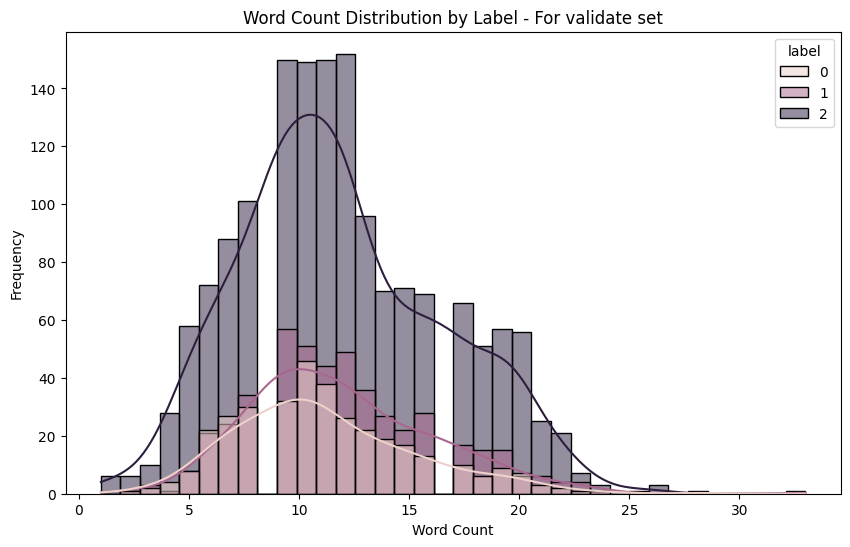

In [12]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_df,"train")
word_count_distribution(validate_df,"validate")

Wordcloud on train set


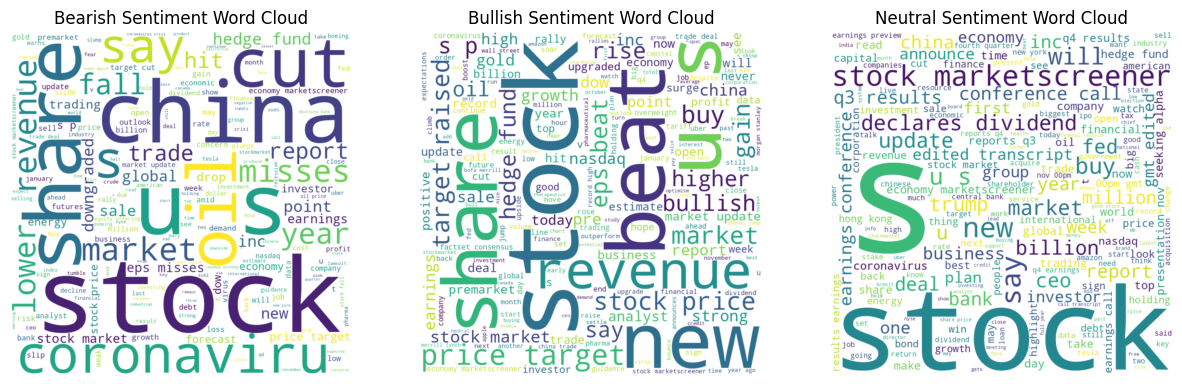

Wordcloud on validate set


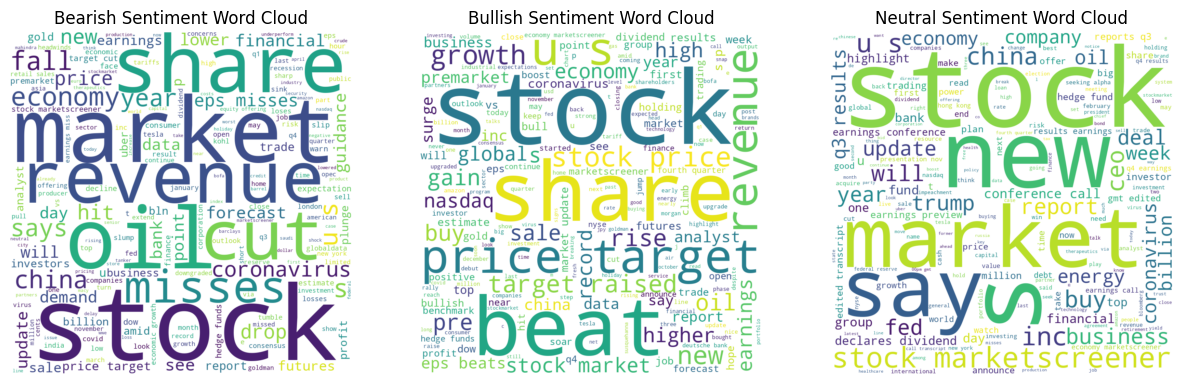

In [13]:
# Creating wordcloud for train set for three sentiment labels - Bearish, Bullish and Neutral tweets
def generate_word_cloud(df):
    bearish_tweets = " ".join(df[df['label'] == 0]['clean_text'])
    bullish_tweets = " ".join(df[df['label'] == 1]['clean_text'])
    neutral_tweets = " ".join(df[df['label'] == 2]['clean_text'])

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bearish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bearish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bullish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bullish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(neutral_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Neutral Sentiment Word Cloud')
    plt.axis('off')

    plt.show()

# Generating wordclouds for train and validate datasets
counter=0
for df in [train_df,validate_df]:
    # setting title of plots
    if counter==0:
        print("Wordcloud on train set")
    else:
        print("Wordcloud on validate set")
    counter+=1
    generate_word_cloud(df)

In [14]:
#  Treating class imbalance and using combination of both oversampler and undersampler
def handle_class_imbalance(df):
    oversampler = RandomOverSampler(sampling_strategy='auto')
    undersampler = RandomUnderSampler(sampling_strategy='auto')

    X = df['clean_text'].values.reshape(-1, 1)
    y = df['label']

    X_over, y_over = oversampler.fit_resample(X, y)
    X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)

    df_balanced = pd.DataFrame({'clean_text': X_balanced.flatten(), 'label': y_balanced})
    return df_balanced

In [15]:
# lst_df=[]
# for df in [train_df, validate_df]:
#     final_df = handle_class_imbalance(df)
#     lst_df.append(final_df)

# train_final_df = lst_df[0]
# validate_final_df = lst_df[1]

In [16]:
train_final_df = train_df
validate_final_df = validate_df

In [17]:
# Perform text data analysis - Word count distribution
# def word_count_distribution(df,run_mode):
#     df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
#     plt.figure(figsize=(10, 6))
#     sns.histplot(data=df, x='word_count', hue='label', kde=True)
#     plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
#     plt.xlabel('Word Count')
#     plt.ylabel('Frequency')
#     plt.show()
# # Calling word count distribution function
# word_count_distribution(train_final_df,"train")
# word_count_distribution(validate_final_df,"validate")

In [18]:
train_final_df.head(5)

,text,label,clean_text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...,9
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...,13
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ...",13
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral,6
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut,9


In [19]:
validate_final_df.head(5)

,text,label,clean_text,word_count
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook,6
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp...",10
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city,8
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold,6
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell,6


In [20]:
X = list(train_final_df['clean_text'])
y = list(train_final_df['label'])

In [21]:
# Split the data into training and validation sets
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [22]:
import torch
from transformers import BertweetTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy
#from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.4.0+cu121', '4.42.4')

In [23]:
torch.cuda.is_available()

True

In [24]:
# Load the BERTweet tokenizer and model
tokenizer = BertweetTokenizer.from_pretrained('vinai/bertweet-base')
model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from transformers import BertweetTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

In [26]:
# Function to tokenize data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # Adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the data
train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(X_test, y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Step 0/478 Loss 1.0977632999420166
Epoch 1 Step 10/478 Loss 0.7995889782905579
Epoch 1 Step 20/478 Loss 0.9304354786872864
Epoch 1 Step 30/478 Loss 0.7747426629066467
Epoch 1 Step 40/478 Loss 0.7287716269493103
Epoch 1 Step 50/478 Loss 0.7183728814125061
Epoch 1 Step 60/478 Loss 1.0050010681152344
Epoch 1 Step 70/478 Loss 0.908540666103363
Epoch 1 Step 80/478 Loss 0.9435862302780151
Epoch 1 Step 90/478 Loss 0.7317512035369873
Epoch 1 Step 100/478 Loss 0.7354938387870789
Epoch 1 Step 110/478 Loss 0.609233021736145
Epoch 1 Step 120/478 Loss 0.8209900259971619
Epoch 1 Step 130/478 Loss 0.6041679382324219
Epoch 1 Step 140/478 Loss 0.7318234443664551
Epoch 1 Step 150/478 Loss 0.7845993638038635
Epoch 1 Step 160/478 Loss 0.7469353675842285
Epoch 1 Step 170/478 Loss 0.6908254027366638
Epoch 1 Step 180/478 Loss 0.6804272532463074
Epoch 1 Step 190/478 Loss 0.4095044434070587
Epoch 1 Step 200/478 Loss 0.48411014676094055
Epoch 1 Step 210/478 Loss 0.4174667000770569
Epoch 1 Step 220/478 L

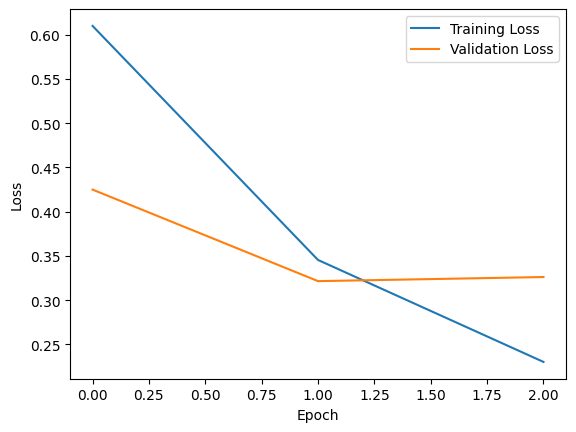

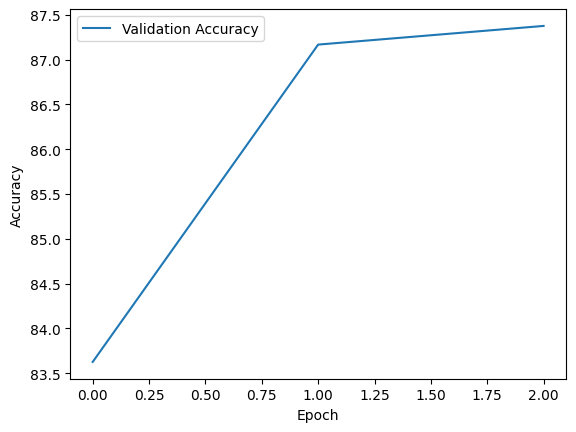

In [ ]:
# Early stopping parameters
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
model_save_path = '/content/drive/MyDrive/Research NLP/BerTweet_wo_class_imbalance'

# Training and evaluation loop
training_stats = []
for epoch in range(3):  # specify the number of epochs
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}/{len(train_dataloader)} Loss {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    print(f"Epoch {epoch+1} Validation Accuracy: {avg_val_accuracy}")
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss {avg_val_loss}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss}")
            break

print("Training complete.")

# Load the best model for further evaluation or use
model = RobertaForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertweetTokenizer.from_pretrained(model_save_path)

# Plot the training and validation loss
train_loss_values = [stat['Training Loss'] for stat in training_stats]
val_loss_values = [stat['Valid. Loss'] for stat in training_stats]

plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
val_accuracy_values = [stat['Valid. Accur.'] for stat in training_stats]

plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Inference data

In [28]:
# Drop word_count column
validate_final_df.drop(columns=['word_count'], inplace=True)

In [29]:
validate_final_df.columns

Index(['text', 'label', 'clean_text'], dtype='object')

In [30]:
# Tokenize the validation data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the validation data
texts = validate_final_df['clean_text'].tolist()
labels = validate_final_df['label'].tolist()

validate_input_ids, validate_attention_masks, validate_labels = tokenize_data(texts, labels)

# Create DataLoader for the validation data
validate_dataset = TensorDataset(validate_input_ids, validate_attention_masks, validate_labels)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False)

# Function to perform predictions
def predict(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    return predictions, true_labels

# Perform predictions on the validation data
predictions, true_labels = predict(model, validate_dataloader)

# Display results
result_df = validate_final_df.copy()
result_df['predicted_label'] = predictions
print(result_df)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                                                   text  label  \
0     $ALLY - Ally Financial pulls outlook https://t...      0   
1     $DELL $HPE - Dell, HPE targets trimmed on comp...      0   
2     $PRTY - Moody's turns negative on Party City h...      0   
3                      $SAN: Deutsche Bank cuts to Hold      0   
4                     $SITC: Compass Point cuts to Sell      0   
...                                                 ...    ...   
2383  Stocks making the biggest moves midday: TD Ame...      2   
2384  Stocks making the biggest moves premarket: Fit...      2   
2385  Stocks making the biggest moves premarket: Hom...      2   
2386  Stocks making the biggest moves premarket: TD ...      2   
2387         TCO, NNVC, GPOR and JE among midday movers      2   

                                             clean_text  predicted_label  
0                 $ally - ally financial pulls outlook                 0  
1     $dell $hpe - dell, hpe targets trimmed on comp...  

In [31]:
import pandas as pd
# Save data to location
result_df.to_csv("/content/drive/MyDrive/Research NLP/Results/bertweet_wo_class_imbalance/bertweet_wo_class_imbalance.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Extract actual and predicted labels
y_true = result_df['label']
y_pred = result_df['predicted_label']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8890284757118928
Precision: 0.8487006353467189
Recall: 0.8666908483054483
F1 Score: 0.8560357210675585
Confusion Matrix:
 [[ 303    8   36]
 [  23  385   67]
 [  75   56 1435]]


Interpretation of model results

Accuracy
Accuracy: 0.873

Interpretation: This means that 87.3% of the overall predictions made by your model are correct. Accuracy is a measure of the proportion of true results (both true positives and true negatives) among the total number of cases examined. However, it does not differentiate between the types of errors and can be misleading if the class distribution is imbalanced.
Precision
Precision: 0.824

Interpretation: This means that when your model predicts a certain class, 82.4% of those predictions are correct. Precision is a measure of the accuracy of the positive predictions. It is important when the cost of false positives is high.
Recall
Recall: 0.845

Interpretation: This indicates that your model correctly identifies 84.5% of the actual instances of each class. Recall (or sensitivity) measures the ability of the model to find all the relevant cases (true positives). It is important when the cost of false negatives is high.
F1 Score
F1 Score: 0.834

Interpretation: The F1 score is the harmonic mean of precision and recall, giving a balance between the two. An F1 score of 0.834 suggests that your model has a good balance between precision and recall.
Confusion Matrix
Confusion Matrix:

lua
Copy code
[[ 282   17   48]
 [  24  390   61]
 [  79   74 1413]]
Interpretation: The confusion matrix provides a more detailed breakdown of the model's performance:
Row 1 (Actual class 0):
282 instances of class 0 were correctly predicted as class 0 (true positives).
17 instances of class 0 were incorrectly predicted as class 1 (false positives).
48 instances of class 0 were incorrectly predicted as class 2 (false positives).
Row 2 (Actual class 1):
24 instances of class 1 were incorrectly predicted as class 0 (false negatives).
390 instances of class 1 were correctly predicted as class 1 (true positives).
61 instances of class 1 were incorrectly predicted as class 2 (false positives).
Row 3 (Actual class 2):
79 instances of class 2 were incorrectly predicted as class 0 (false negatives).
74 instances of class 2 were incorrectly predicted as class 1 (false positives).
1413 instances of class 2 were correctly predicted as class 2 (true positives).
Overall Interpretation
Accuracy: Indicates the overall correctness of the model but might not give a complete picture if there are imbalances between classes.
Precision: Suggests that the model is good at predicting positive instances, but might produce some false positives.
Recall: Shows that the model is good at identifying true instances of each class but might miss some.
F1 Score: Balances precision and recall, indicating a well-rounded model performance.
Confusion Matrix: Provides insight into the specific types of errors the model is making, which can help in understanding where improvements might be needed.
From these results, it appears that your model is performing quite well, but there may be room for improvement in reducing false positives and false negatives. Here are some specific actions you could take:

Actions to Improve Model Performance
Analyze Misclassifications: Examine the instances that are being misclassified. Understand if there are patterns or common features among these misclassified instances that the model is not capturing.

Feature Engineering: Improve the features used in the model. This could include creating new features, removing irrelevant ones, or transforming existing features.

Model Tuning: Adjust the hyperparameters of your model to find a better configuration that might reduce misclassifications.

Data Augmentation: Increase the amount of training data by generating synthetic samples, especially if some classes are underrepresented.

Ensemble Methods: Combine multiple models to improve performance. Techniques like bagging, boosting, or stacking can often lead to better generalization.

Threshold Adjustment: For models that output probabilities, adjusting the decision threshold can help balance precision and recall according to the specific needs of your application.

Class Rebalancing: If the classes are imbalanced, consider techniques like oversampling the minority class, undersampling the majority class, or using more sophisticated methods like SMOTE to balance the training data.

By applying these techniques, you can iteratively improve your model's performance, reducing false positives and false negatives.